# Access Copernicus Land, Atmosphere and Marine data

This notebook allows to access to Copernicus data, using both datasets provided by Google Earth Engine Catalog and Copernicus APIs.
The data used in this notebook are stored in memory using these services without downloading data.

## Import libraries
List of relevant libraries used: 
- matplotlib
- xarray
- pydap
- cartopy
- numpy
- lxml
- ee / geemap

In [ ]:
# #Install the following libraries using pip if not working on Binder (it may be required to restart the kernel):
#!pip install lxml
#!pip install cdsapi
#!pip install hda

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import getpass
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

---

## Copernicus Marine data from OPeNDAP API

Reference material for this code:
- https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python
- https://www.youtube.com/watch?v=ZJoRZYiMQcM&ab_channel=CopernicusMarineService

First of all define a function able to retrieve the data from Copernicus Marine API, using OPeNDAP. The data used for this example can be accessed from [here](https://resources.marine.copernicus.eu/product-detail/MEDSEA_ANALYSISFORECAST_PHY_006_013/DATA-ACCESS):

In [ ]:
# #! /usr/bin/env python3
# # -*- coding: utf-8 -*-
# __author__ = "Copernicus Marine User Support Team"
# __copyright__ = "(C) 2022 E.U. Copernicus Marine Service Information"
# __credits__ = ["E.U. Copernicus Marine Service Information"]
# __license__ = "MIT License - You must cite this source"
# __version__ = "202104"
# __maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
# __email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"

def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

The **id** and **password** are the same used for logging in the Copernicus Marine website.

In [ ]:
# Required the data using the function copernicusmarine_datastore
data_store = copernicusmarine_datastore('med-cmcc-tem-an-fc-d', 'CMEMS_ID', 'CMEMS_PASS')

The data_store variable can be open with xarray library, using the open_dataset function:

In [ ]:
DS = xr.open_dataset(data_store).sel(time='2021-01-01', method='nearest')
DS

Is possible to slice the xarray dataset using lat/lon and creating a cropped dataset over the area of interest:

In [ ]:
min_lon = 12
min_lat = 40 
max_lon = 19
max_lat = 46 


cropped_ds = DS.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_ds

The dataset can be plotted or used for further analysis:

In [ ]:
temp_mod = cropped_ds['thetao'].sel(depth=0,method='nearest').squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([11,20, 39, 46],crs=ccrs.PlateCarree())

f.suptitle('Adriatic Sea surface temperature', fontsize=28)
im = ax.pcolor(temp_mod['lon'].data,temp_mod['lat'].data, temp_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('°C', rotation =270, fontsize=23,labelpad=15)

---

## Copernicus Atmosphere Monitoring Service (CAMS) data using cdsapi library

Reference: https://github.com/ecmwf/cdsapi/issues/25

The id and key to access CAMS API can be retrieved as explained at this link: https://ads.atmosphere.copernicus.eu/api-how-to.

In [ ]:
c = cdsapi.Client("https://ads.atmosphere.copernicus.eu/api/v2","ads_key") #change ads_key

It is possible to define the download parameters using the tab form provided by CAMS (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=form) and pass them to the **retrive** function of the cdsapi library.

In [ ]:
# API request
params = {'format': 'netcdf',
        'variable': 'particulate_matter_2.5um',
        'model': 'ensemble',
        'date': '2022-04-18/2022-04-20',
        'level': '0',
        'type': 'analysis',
        'time':'00:00',
        'leadtime_hour': 0,
        'area': [48,6, 43, 13]}

# retrieve the location of the file
fl = c.retrieve('cams-europe-air-quality-forecasts', params) 

# load into memory 
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read()).mean(dim='time')

The CAMS dataset can be plotted as follow:

In [ ]:
pm_mod = ds['pm2p5_conc'].sel(level=0,method='nearest').squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([5,14, 42, 49],crs=ccrs.PlateCarree())

f.suptitle('Po Valley PM2.5', fontsize=28)
im = ax.pcolor(pm_mod['longitude'].data,pm_mod['latitude'].data, pm_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('Concentration', rotation =270, fontsize=23,labelpad=15)

----

## WEkEO DIAS

Reference: https://www.wekeo.eu/docs/webdav-wekeodrive <br>
WEkEO HDA API: https://github.com/ecmwf/hda <br>
WEkEO > Dashboard > JupyterHub

### Install the WEkEO HDA API
Follow the instructions at this link for installation: https://www.wekeo.eu/docs/hda-python-lib
You should create a ".hdarc" file inside your user folder with your WEkEO username and password. 

For Binder upload ".hdarc" file in your folder.

In [2]:
import hda
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Initialize HDA client
c = hda.Client()  #upload .hdarc file in the folder

Create the query for data request.
1. Go on WEkEO data viewer: https://www.wekeo.eu/data?view=viewer&initial=1
2. Select the data from Catalogue. For exaple ERA5 Data
3. Click on "Subset and download" on the layer menu
4. Select the parameters and then "Show API request"
5. Insert the API request in the following query variable

In [25]:
query = {
  "datasetId": "EO:ECMWF:DAT:ERA5_HOURLY_VARIABLES_ON_PRESSURE_LEVELS",
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "temperature"
      ]
    },
    {
      "name": "pressure_level",
      "value": [
        "1000"
      ]
    },
    {
      "name": "year",
      "value": [
        "2020"
      ]
    },
    {
      "name": "month",
      "value": [
        "12"
      ]
    },
    {
      "name": "day",
      "value": [
        "31"
      ]
    },
    {
      "name": "time",
      "value": [
        "12:00"
      ]
    },
    {
      "name": "product_type",
      "value": [
        "ensemble_mean"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": "netcdf"
    }
  ]
}

# The following line runs the query
matches = c.search(query)

# The following line prints the products returned by the query
print(matches)

SearchResults[items=1,volume=513K,jobId=73gUbMe2P1H6wLy906rp1d4BfCY]


In [26]:
fl = matches.results[0]['url']

In [27]:
# load into memory 
with urlopen(fl) as f:
    ds = xr.open_dataset(f.read()).mean(dim='time')

In [28]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
Data variables:
    t          (latitude, longitude) float32 264.6 264.6 264.6 ... 261.0 261.0

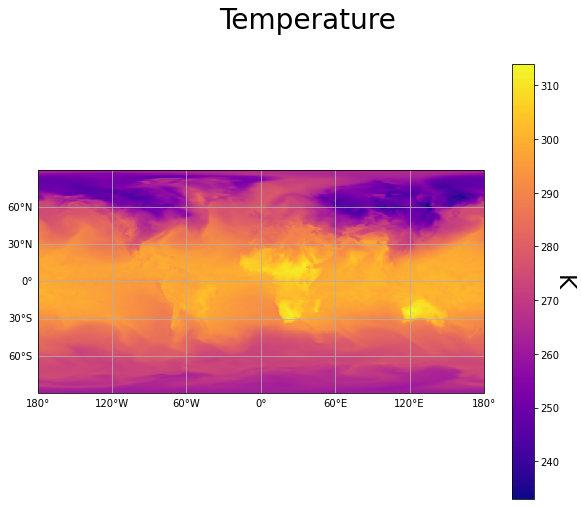

In [29]:
pm_mod = ds['t'].squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([-180,180, -90, 90],crs=ccrs.PlateCarree())

f.suptitle('Temperature', fontsize=28)
im = ax.pcolor(pm_mod['longitude'].data,pm_mod['latitude'].data, pm_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('K', rotation =270, fontsize=23,labelpad=15)

---

# Copernicus C3S (optional) - slow download 

C3S is slow at downloading data

In [ ]:
f = open('keys.json')
keys = json.load(f)
c = cdsapi.Client("https://cds.climate.copernicus.eu/api/v2", "C3S_KEY")

# API request
params = {
        'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': 'temperature',
        'pressure_level':'1000',
        'year':['2020'],
        'month':['07'],
        'day': ['01'],
        'time': ['12:00'],
        'grid': [0.25, 0.25],
        'area': [48,6, 43, 12]}

# retrieve the location of the file
fl = c.retrieve('reanalysis-era5-pressure-levels', params) 

# load into memory 
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())


---

## Copernicus Land Cover WMS

In [ ]:
# load owslib library
from owslib.wms import WebMapService

# Create your WebMapService object
wms = WebMapService('https://viewer.globalland.vgt.vito.be/geoserver/ows?service=WMS&request=GetCapabilities')

#Show the number of available layers
sorted(list(wms.contents.keys()))

In [ ]:
%matplotlib inline
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def getMap(layerName,bbox,filename):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open(filename,'wb')
    tmpfile.write(img.read())
    tmpfile.close()
    
getMap('PV_MEP:PROBAV_S10_TOC_1KM_NDVI', (0,40,15,50), 'PV_MEP:PROBAV_S10_TOC_1KM_NDVI.png')
image_fore = mpimg.imread('PV_MEP:PROBAV_S10_TOC_1KM_NDVI.png')
fig = plt.figure(figsize=(12,7))

img_fore = plt.imshow(image_fore)

---

## Copernicus Land Cover WCS

Reference: https://land.copernicus.eu/global/product-access <br>
https://git.wur.nl/isric/soilgrids/soilgrids.notebooks <br>
https://cybergisxhub.cigi.illinois.edu/wp-content/uploads/2019/12/OGC_Services.html <br>
https://publicwiki.deltares.nl/display/OET/WCS+primer

In [ ]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('https://viewer.globalland.vgt.vito.be/geoserver/ows?service=WCS&request=GetCapabilities')

In [ ]:
#Get the title of the service
print(wcs.identification.title)

# List the available first ten contents 
sorted(list(wcs.contents.keys()))[0:10]

In [ ]:
layerid = 'CGLS__ba300_v1_333m_FDOB_DEKAD'
wcs_layer = wcs.contents[layerid]

In [ ]:
#Title
print('Layer title :', wcs_layer.title)
#bounding box
print('BoundingBox :', wcs_layer.boundingBoxWGS84)
# supported data formats - we'll use geotiff
print('Formats :', wcs_layer.supportedFormats)

In [ ]:
format_wcs = 'image/jpeg'

output = wcs.getCoverage(identifier=[layerid, ], format=format_wcs)

In [ ]:
wcsfn = layerid + '.jpeg'
with open(wcsfn, 'wb') as fh:
    fh.write(output.read())

In [ ]:
wcsdt = xr.open_dataset(wcsfn)

print(wcsdt.data_vars)

plt.figure(figsize=(20,10))

wcsdt.Band1.plot()

plt.show()